In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [129]:
# imaged object
CUBE_SIZE = 1.0

# ray origin and direction
RADIUS = 2
HEIGHT = 2
N_THETA = 16
N_Z = 20

In [130]:
# define the object (a cube)
def is_inside_cube(point, cube_size):
    half = cube_size / 2
    return all(-half <= coord <= half for coord in point)

is_inside_cube((0.5,-0.2, 0.3), CUBE_SIZE) # true
# is_inside_cube((1.0,0, 0.4), CUBE_SIZE) # false

True

In [131]:
# ray generator (cylindrical)
def generate_rays(radius, height, n_theta, n_z):
    thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)   # n_theta angles around the cube
    zs = np.linspace(-height/2, height/2, n_z)                  # n_z rows of rays from -height/2 to height/2

    origins, directions = [], []
    for z in zs:
        for theta in thetas:
            x = radius * np.cos(theta)
            y = radius * np.sin(theta)
            origins.append([x, y, z])
            directions.append([-x, -y, 0.0]) # direction: inward to axis, no z component
    return np.array(origins), np.array(directions)


In [132]:
origins, directions = generate_rays(RADIUS, HEIGHT, N_THETA, N_Z) # shape: (360, 3), (360, 3)

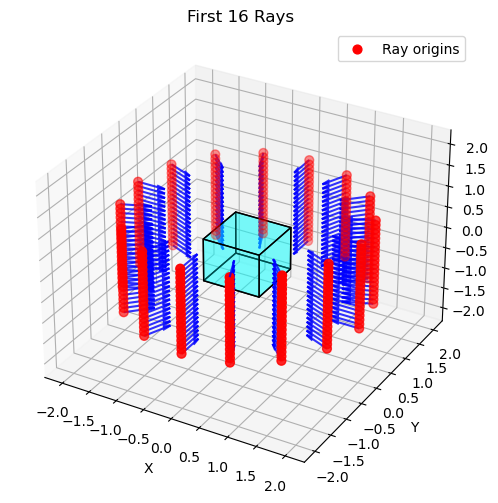

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_first_rays(origins, directions, n_theta, cube_size, arrow_length=0.5):
    """
    Plot the first N_THETA rays from given origins and directions.
    Each ray is drawn as an arrow pointing inward toward the center.
    """
    # take the first n_theta rays
    O = origins[:n_theta]
    D = directions[:n_theta]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection="3d")

    # plot ray origins
    ax.scatter(O[:,0], O[:,1], O[:,2], color="red", s=40, label="Ray origins")

    # plot arrows for each ray direction
    for o, d in zip(O, D):
        ax.quiver(o[0], o[1], o[2], d[0], d[1], d[2],
                  length=arrow_length, normalize=True, color="blue", alpha=0.8)

     # draw the cube
    half = cube_size / 2
    vertices = np.array([[-half, -half, -half],
                         [ half, -half, -half],
                         [ half,  half, -half],
                         [-half,  half, -half],
                         [-half, -half,  half],
                         [ half, -half,  half],
                         [ half,  half,  half],
                         [-half,  half,  half]])
    
    faces = [[vertices[j] for j in [0,1,2,3]],
             [vertices[j] for j in [4,5,6,7]],
             [vertices[j] for j in [0,1,5,4]],
             [vertices[j] for j in [2,3,7,6]],
             [vertices[j] for j in [1,2,6,5]],
             [vertices[j] for j in [4,7,3,0]]]

    cube = Poly3DCollection(faces, facecolors='cyan', edgecolors='k', alpha=0.3)
    ax.add_collection3d(cube)

    # mark the center
    #ax.scatter(0, 0, 0, color="black", s=80, label="Center")

    # equal scaling
    max_range = np.max(np.linalg.norm(O, axis=1))
    for axis in 'xyz':
        getattr(ax, f'set_{axis}lim')([-max_range, max_range])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"First {N_THETA} Rays")
    ax.legend()
    plt.show()

# Example usage:
plot_first_rays(origins, directions, N_THETA*N_Z, CUBE_SIZE)


In [134]:
# inspecting the z values of the rays
z_values = origins[:, 2]

print("Z range:", z_values.min(), "to", z_values.max())
print("Unique z-levels:", np.unique(z_values))
print("Mean Z:", z_values.mean())

Z range: -1.0 to 1.0
Unique z-levels: [-1.         -0.89473684 -0.78947368 -0.68421053 -0.57894737 -0.47368421
 -0.36842105 -0.26315789 -0.15789474 -0.05263158  0.05263158  0.15789474
  0.26315789  0.36842105  0.47368421  0.57894737  0.68421053  0.78947368
  0.89473684  1.        ]
Mean Z: -8.881784197001253e-17


In [135]:
# ray marching parameters
STEPS = 200
STEP_SIZE = 0.02

In [136]:
# ray object intersection
# we march along the ray
# if we hit return 0; ow return 1

def cast_ray(origin, direction, steps, step_size, cube_size):
    pos = np.array(origin, dtype=float)
    dir_norm = direction / np.linalg.norm(direction)

    for _ in range(steps):
        pos += dir_norm * step_size
        #print(pos)
        if is_inside_cube(pos, cube_size=cube_size):
            return 0 # blocked
    return 1 # transmitted

In [137]:
block_trans = {'block': 0, 'trans': 0}
for o, d in zip(origins, directions):
    if cast_ray(o, d, STEPS, STEP_SIZE, CUBE_SIZE) == 1:
        block_trans['trans'] += 1
    else:
        block_trans['block'] += 1

print(block_trans)

{'block': 160, 'trans': 160}


In [138]:
# collect projection data
def collect_data(radius, height, n_theta, n_z, steps, step_size, cube_size):
    origins, directions = generate_rays(radius, height, n_theta, n_z)
    results = []
    for o, d in zip(origins, directions):
        results.append(cast_ray(o, d, steps, step_size, cube_size))
    return np.array(results).reshape(n_z, n_theta)

In [139]:
# zero = blocked
# one = transmitted

ray_results = collect_data(RADIUS, HEIGHT, N_THETA, N_Z, STEPS, STEP_SIZE, CUBE_SIZE)
print(ray_results.shape)

val, count = np.unique(ray_results, return_counts=True)
print(val[0], count[0])
print(val[1], count[1])

(20, 16)
0 160
1 160


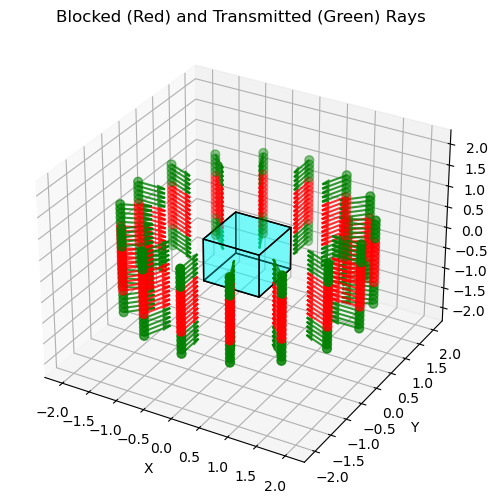

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def plot_rays_with_cube(origins, directions, ray_results, arrow_length=0.5):
    ray_results_flat = ray_results.flatten()
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    # --- draw the cube (centered at origin, unit length)
    half = 0.5
    vertices = np.array([[-half, -half, -half],
                         [ half, -half, -half],
                         [ half,  half, -half],
                         [-half,  half, -half],
                         [-half, -half,  half],
                         [ half, -half,  half],
                         [ half,  half,  half],
                         [-half,  half,  half]])
    
    faces = [[vertices[j] for j in [0,1,2,3]],
             [vertices[j] for j in [4,5,6,7]],
             [vertices[j] for j in [0,1,5,4]],
             [vertices[j] for j in [2,3,7,6]],
             [vertices[j] for j in [1,2,6,5]],
             [vertices[j] for j in [4,7,3,0]]]
    
    cube = Poly3DCollection(faces, facecolors='cyan', edgecolors='k', alpha=0.3)
    ax.add_collection3d(cube)

    # --- plot rays
    colors = np.where(ray_results_flat == 1, 'green', 'red')  # 1=transmitted(green), 0=blocked(red)
    for o, d, c in zip(origins, directions, colors):
        ax.quiver(o[0], o[1], o[2], d[0], d[1], d[2],
                  length=arrow_length, normalize=True, color=c, alpha=0.8)

   # --- plot origins (matching color)
    ax.scatter(origins[:,0], origins[:,1], origins[:,2], c=colors, s=40)

    # --- axes setup
    max_range = np.max(np.linalg.norm(origins, axis=1))
    for axis in 'xyz':
        getattr(ax, f'set_{axis}lim')([-max_range, max_range])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Blocked (Red) and Transmitted (Green) Rays")
    plt.show()

plot_rays_with_cube(origins, directions, ray_results)


In [141]:
import numpy as np

def is_inside_cube(point, cube_size=1.0):
    half = cube_size / 2
    return all(-half <= coord <= half for coord in point)

def reconstruct_fill_from_blocked(origins, directions, ray_results,
                                  grid_size=100, extent=1.5,
                                  cube_size=1.0, max_dist=3.0, step=0.03):
    """
    Reconstruct a volume starting empty and filling voxels where rays
    are blocked by the object (based on transmission results).
    """
    volume = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)

    def world_to_grid(point):
        idx = ((point + extent) / (2 * extent) * (grid_size - 1)).astype(int)
        return np.clip(idx, 0, grid_size - 1)

    # normalize directions
    directions = directions / np.linalg.norm(directions, axis=1, keepdims=True)

    for o, d, r in zip(origins, directions, ray_results):
        if r == 1:  # transmitted → nothing to fill
            continue
        # blocked ray: walk along its path
        n_steps = int(max_dist / step)
        for i in range(n_steps):
            p = o + d * (i * step)
            if is_inside_cube(p, cube_size):   # if inside true object
                x, y, z = world_to_grid(p)
                volume[x, y, z] = 1            # fill voxel
    return volume


In [126]:
print(origins.shape)
print(directions.shape)
print(ray_results.flatten().shape)

(1280, 3)
(1280, 3)
(1280,)


In [142]:
# reconstruct (fill-based)
volume = reconstruct_fill_from_blocked(origins, directions, ray_results.flatten(),
                                       grid_size=100, extent=1.5,
                                       cube_size=1.0)

In [143]:
np.save("filled_2.npy", volume)